In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install EMD-signal

In [ ]:
#!rm -r /content/drive/MyDrive/filtered/subjects

In [ ]:
!unzip /content/drive/MyDrive/filtered/tr.zip -d /content/drive/MyDrive/filtered/subjects/

In [ ]:
import numpy as np
import glob
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
import urllib.request
import scipy.io as io
import h5py
import progressbar
from __future__ import print_function
#from PyEMD import CEEMDAN
#from PyEMD.visualisation import Visualisation
#import unittest

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/wsp/Binalood.xlsx')

In [ ]:
data.head()

,awind,swind,direction,tem,rad,amp
0,8.7,11.0,296.5,25.8,749.0,326.730694
1,9.2,10.0,301.1,26.1,767.0,425.101084
2,9.4,8.0,292.8,26.3,773.0,332.958747
3,9.3,10.0,301.3,26.4,760.0,424.806083
4,10.6,7.0,309.2,26.7,784.0,319.855524


In [ ]:
data.shape

(73500, 6)

In [ ]:
data = data.dropna()
data.shape

(65398, 6)

In [ ]:
np.max(data, axis = 0)

awind          21.000000
swind         360.000000
direction     360.000000
tem            41.100000
rad          1055.000000
amp           565.523175
dtype: float64

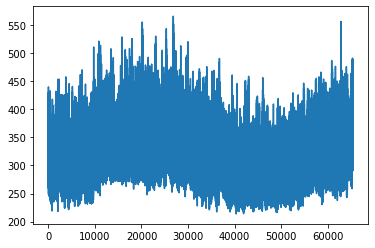

In [ ]:
plt.plot(data['amp'])

In [ ]:
data = pd.read_excel(datasets_names[0])
for i in range(1, 4):
  temp = pd.read_excel(datasets_names[i])
  data = pd.concat([data, temp])
data.shape

(293856, 8)

In [ ]:
del data
del temp

In [ ]:
datasets_names = glob.glob(os.path.join('/content/drive/MyDrive/wsp','*.xlsx'))

# Data

In [ ]:
def ceemdan_Run(S_train, parallel=False, max_imf = 11 ):
  ceemdan = CEEMDAN(parallel = parallel)
  cIMFs = ceemdan(S_train, max_imf=max_imf)
  return cIMFs

In [ ]:
#cIMFs= ceemdan_Run(data[0,:256], parallel=True, max_imf = 2)
#cIMFs.shape

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(data, target):
  feature = {
      'data': _float_feature(data),
      'target': _float_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()


In [ ]:
!mkdir /content/drive/MyDrive/wsp/data

In [ ]:
!mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
#!rm -r /content/data/val

# Create Tfrecords

In [ ]:
def create_tfrecs(subjects_lists, save_path = '/content/data'):
  i = 0
  num_all = []
  with progressbar.ProgressBar(max_value=len(subjects_lists)) as bar:
    for rec in subjects_lists:
      data = pd.read_excel(rec)
      data = data.dropna()
      data = data.to_numpy()
      data = data.astype(np.float64)
      number_of_arrays = data.shape[0]//256
      num_all.append(number_of_arrays)
      rec = rec.split('/')[-1].split('.xlsx')[0]
      with tf.io.TFRecordWriter(os.path.join(save_path, rec + '.tfrec')) as writer:
        for j in range(number_of_arrays):
          sub_data = data[j*256:(j+1)*256,:]
          target = sub_data[:,-1].copy()
          sub_data = sub_data[:,:-1]

          #for k in range(6):
          #  cIMF = ceemdan_Run(sub_data[k,:], parallel=True, max_imf = 2)
          #  sub_data = np.concatenate((sub_data, cIMF), axis=0)
          #print(sub_data.shape)

          example = serialize_example(sub_data.reshape(-1,1), target.reshape(-1,1))
          writer.write(example)
      i +=1
      bar.update(i)
  return num_all

In [ ]:
datasets_names

['/content/drive/MyDrive/wsp/Binalood.xlsx',
 '/content/drive/MyDrive/wsp/Davarzan.xlsx',
 '/content/drive/MyDrive/wsp/Ghadamgah.xlsx',
 '/content/drive/MyDrive/wsp/Khaf.xlsx',
 '/content/drive/MyDrive/wsp/Jangaal.xlsx']

In [ ]:
save_path = '/content/drive/MyDrive/wsp/data'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_samples = create_tfrecs(datasets_names, save_path = save_path)
num_samples

100% (5 of 5) |##########################| Elapsed Time: 0:00:18 Time:  0:00:18


[255, 265, 287, 308, 314]

In [ ]:
num_samples = [255, 265, 287, 308, 314]

# Generator

In [ ]:
# Create a dictionary describing the features.
feature_description = {
    'data': tf.io.FixedLenFeature([256*5], tf.float32, default_value=[0.0]*256*5),
    'target': tf.io.FixedLenFeature([256], tf.float32, default_value=[0.0]*256),
  }

def _parse_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def preprocess(features,effesionet=True):
  data = features['data']
  #data = tf.io.decode_raw(data, tf.int16)
  label = features['target']
  #label = tf.io.decode_raw(label, tf.int16)
  return data, label


def normalize(data ,label):
  #standard
  data = tf.cast(data, tf.float32)
  scale = tf.constant(max_data) - tf.constant(min_data)
  offset = tf.constant(min_data)

  data -= offset
  data /= scale
  label = tf.cast(label, tf.float32)
  scale =  tf.constant([max_label]) - tf.constant([min_label])
  offset = tf.constant([min_label])
  label -= offset
  label /= scale
  return data , label

@tf.function
def augment(data,label):

  return data , label

def Resize(data,label):
  data = tf.reshape(data, [256,5])
  label = tf.reshape(label, [256,1])
  return data , label


In [ ]:
def find_stats(all_tfrecs):
  ds_stat= tf.data.TFRecordDataset(all_tfrecs)
  ds_stat = ds_stat.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(100)
  ds_stat  =  ds_stat.map(preprocess)
  ds_stat  = ds_stat.map(Resize).batch(16,drop_remainder=True)

  mean_data = np.zeros((5,))
  std_data = np.zeros((5,))
  max_data = np.ones((5,))*(-10000000000) # -inf
  min_data = np.ones((5,))*(10000000000) #+inf

  mean_label = 0
  std_label = 0
  max_label = -10000000000
  min_label = 10000000000
  k = 0
  for i in ds_stat:
    data1, label = i
    mean_data = mean_data + np.mean(np.mean(data1.numpy(),axis=1),axis=0)
    std_data = std_data + np.std(np.std(data1.numpy(),axis=1),axis=0)
    mean_label = mean_label + np.mean(np.mean(label.numpy(),axis=1),axis=0)
    std_label = std_label + np.std(np.std(label.numpy(),axis=1),axis=0)

    data =np.max(np.max(data1,axis=1),axis=0)
    max_data[np.where(max_data< data)] = data[np.where(max_data< data)]
    data =np.min(np.min(data1,axis=1),axis=0)
    min_data[np.where(min_data> data)] = data[np.where(min_data> data)]

    if np.max(np.max(label.numpy(),axis=1))>max_label:
      max_label = np.max(np.max(label.numpy(),axis=1))
    if np.min(np.min(label.numpy()))<min_label:
      min_label = np.min(np.min(label.numpy()))

    k = k+1
  std_data = std_data/k
  mean_data = mean_data/k
  mean_label = mean_label/k
  std_label = std_label/k
  print('min data')
  print(min_data)
  print('max data')
  print(max_data)
  print('std data')
  print(std_data)
  print('mean data')
  print(mean_data)

  print('std label')
  print(std_label)
  print('mean label')
  print(mean_label)
  print('min label')
  print(min_label)
  print('max label')
  print(max_label)
  del ds_stat
  return min_data, max_data, min_label, max_label

In [ ]:
all_tfrecs = glob.glob(os.path.join('/content/drive/MyDrive/wsp/data','*.tfrec'))
np.random.seed(60)
indices = np.arange(len(all_tfrecs))
np.random.shuffle(indices)
indices.tolist()
test_tfrecs = all_tfrecs[indices[0]]
num_test = num_samples[indices[0]]
val_tfrecs = all_tfrecs[indices[1]]
num_vals = num_samples[indices[1]]
train_tfrecs = [all_tfrecs[indices[i]] for i in range(2,len(all_tfrecs))]
num_train= num_samples[indices[2]] +  num_samples[indices[3]] +  num_samples[indices[4]]

In [ ]:
print(num_test, num_vals, num_train)

255 314 860


In [ ]:
train_tfrecs

['/content/drive/MyDrive/wsp/data/Khaf.tfrec',
 '/content/drive/MyDrive/wsp/data/Ghadamgah.tfrec',
 '/content/drive/MyDrive/wsp/data/Davarzan.tfrec']

In [ ]:
min_data, max_data, min_label, max_label = find_stats(train_tfrecs)
max_data = max_data.tolist()
min_data = min_data.tolist()

min data
[  0.           0.           0.         -18.60000038   0.        ]
max data
[  30.29999924  360.          360.           40.         1200.        ]
std data
[ 0.71320939  6.71210985 18.94165501  1.11519899 33.02555599]
mean data
[  5.52331553  48.54242493 163.28330907  15.77729289 222.05220147]
std label
[7.169572]
mean label
[332.72876]
min label
210.31071
max label
594.70905


In [ ]:
BATCH_SIZE = 6
ds_train = tf.data.TFRecordDataset(train_tfrecs)
ds_train = ds_train.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
ds_train  =  ds_train.map(preprocess)#.map(agment)
ds_train  = ds_train.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
BATCH_SIZE = 6
ds_val= tf.data.TFRecordDataset([val_tfrecs])
ds_val = ds_val.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val  =  ds_val.map(preprocess)
ds_val  = ds_val.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

In [ ]:
data1, label = next(iter(ds_train))
data1.shape

TensorShape([8, 256, 5])

In [ ]:
np.max(np.max(data1,axis = 1), axis = 0)

array([0.8415842 , 0.99722224, 1.        , 0.9558102 , 0.76549995],
      dtype=float32)

In [ ]:
np.min(np.min(data1,axis = 1), axis = 0)

array([0.        , 0.        , 0.        , 0.31751227, 0.        ],
      dtype=float32)

In [ ]:
label.shape

TensorShape([64, 256, 1])

In [ ]:
label.shape

TensorShape([64, 256, 1])

In [ ]:
np.std(data1.numpy())

0.002372507

# model

## Primary Classes

In [ ]:
from tensorflow.keras.activations import selu, relu

class BB (tf.keras.layers.Layer):
  def __init__(self,
               filters = 64,
               kernel_size = 9):
    super(BB, self).__init__()

    self.filters = filters
    self.kernel_size = kernel_size

    self.conv1 = tf.keras.layers.Conv1D(filters, kernel_size, activation=None, padding='same')

    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv1D(filters, kernel_size, activation=None, padding='same')


  def call(self, z, training = True):
    x = self.conv1(z)
    x = self.bn1(x, training = training)
    x = selu(x)

    x = self.conv2(x)
    x = self.bn2(x, training = training)
    x = selu(x)
    x = tf.keras.layers.Add()([x, z])

    x = self.bn3(x, training = training)
    x = selu(x)
    return x

In [ ]:
def tf_max_pool_with_masks(x,
                           ksize = [1,1,2,1],
                           strides = [1,1,2,1],
                           padding = "VALID",
                           data_format='NHWC',
                           output_dtype=tf.dtypes.int64,
                           include_batch_in_index=True):
  """
    x = input tensor of size BTC, B=Batch, T:Time step, C:Channel
    ksize: kernel size for each dim
    strides: strides of each dim
    data_format:channel last or not
    output_dtype: int64 or int32
    include_batch_in_index:An optional boolean. Defaults to True. Whether to include batch dimension in flattened index of argmax.
  """
  input = tf.reshape(x, shape=(x.shape[0], 1, x.shape[1],x.shape[2]))
  output, argmax = tf.nn.max_pool_with_argmax(input,
                                              ksize = [1,1,2,1],
                                              strides = [1,1,2,1],
                                              padding = "VALID",
                                              data_format='NHWC',
                                              output_dtype=tf.dtypes.int64,
                                              include_batch_in_index=True
                                              )

  #a = tf.reshape(output, shape=(-1,1))
  indices = tf.reshape(argmax, shape=(-1,1))
  input_flatten = tf.reshape(input, shape=(-1,1))
  tensor = tf.zeros_like(input_flatten, dtype=tf.float32)
  updates = tf.ones_like(indices, dtype=tf.float32)
  mask = tf.tensor_scatter_nd_update(tensor, indices, updates)
  mask = tf.reshape(mask, shape=x.get_shape().as_list())
  output = tf.reshape(output, shape=(output.shape[0],output.shape[2],output.shape[3]))
  return output, mask

In [ ]:
x = tf.constant(1.0, dtype=tf.float32, shape=(16,16,512))*np.random.rand()

In [ ]:
a,b = tf_max_pool_with_masks(x)

In [ ]:
a.shape

TensorShape([16, 8, 512])

In [ ]:
b.shape

TensorShape([16, 16, 512])

## Model1

In [ ]:
from tensorflow import keras

class eUNet1D (keras.Model):
  def __init__(self,
               kernel_size = 9,
               strides = 2):
    super(eUNet1D, self).__init__()
    self.kernel_size        = kernel_size
    self.strides            = strides
    self.conv1_0 = tf.keras.layers.Conv1D(64, kernel_size, activation='selu', padding='same')
    self.bb1_1 = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2 = BB(filters = 64, kernel_size = self.kernel_size)

    #self.down2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv2_0 = tf.keras.layers.Conv1D(128, kernel_size, activation='selu', padding='same')
    self.bb2_1 = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb2_2 = BB(filters = 128, kernel_size = self.kernel_size)

    #self.down3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv3_0 = tf.keras.layers.Conv1D(256, kernel_size, activation='selu', padding='same')
    self.bb3_1 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_2 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_3 = BB(filters = 256, kernel_size = self.kernel_size)

    #self.down4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv4_0 = tf.keras.layers.Conv1D(512, kernel_size, activation='selu', padding='same')
    self.bb4_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_3 = BB(filters = 512, kernel_size = self.kernel_size)

    #self.down5 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.bb5_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3 = BB(filters = 512, kernel_size = self.kernel_size)

    self.bb5_1_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.up5 =  tf.keras.layers.Conv1DTranspose(filters = 512, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv4_0_ = tf.keras.layers.Conv1D(256, kernel_size, activation='selu', padding='same')
    self.bb4_1_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_2_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_3_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.up4 =  tf.keras.layers.Conv1DTranspose(filters = 256, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv3_0_ = tf.keras.layers.Conv1D(128, kernel_size, activation='selu', padding='same')
    self.bb3_1_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_2_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_3_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.up3 =  tf.keras.layers.Conv1DTranspose(filters = 128, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv2_0_ = tf.keras.layers.Conv1D(64, kernel_size, activation='selu', padding='same')
    self.bb2_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb2_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.up2 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='valid')

    self.bb1_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    #self.up1 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='same')
    self.conv_out = tf.keras.layers.Conv1D(1, 1, activation='sigmoid')



  def call(self, z, training = True):
    """
      z: (btach, time steps, channels)--> input
    """
    #######################################
    ############ Row 1 ####################
    #######################################
    x = self.conv1_0(z)#(None, 256, 64)
    x = self.bb1_1(x) #(None, 256, 64)
    x1 = self.bb1_2(x) #(None, 256, 64)

    #######################################
    ############ Row 2 ####################
    #######################################
    x, mask2 = tf_max_pool_with_masks(x1) #(None, 128, 64)
    x = self.conv2_0(x)
    x = self.bb2_1(x) #(None, 128, 128)
    x2 = self.bb2_2(x) #(None, 128, 128)

    #######################################
    ############ Row 3 ####################
    #######################################
    x, mask3 = tf_max_pool_with_masks(x2) #(None, 64, 128)
    x = self.conv3_0(x)
    x = self.bb3_1(x) #(None, 64, 256)
    x = self.bb3_2(x) #(None, 64, 256)
    x3 = self.bb3_3(x) #(None, 64, 256)

    #######################################
    ############ Row 4 ####################
    #######################################
    x, mask4 = tf_max_pool_with_masks(x3) #(None, 32, 256)
    x = self.conv4_0(x)
    x = self.bb4_1(x) #(None, 32, 512)
    x = self.bb4_2(x) #(None, 32, 512)
    x4 = self.bb4_3(x) #(None, 32, 512)

    #######################################
    ############ Row 5 ####################
    #######################################
    x, mask5 = tf_max_pool_with_masks(x4) #(None, 16, 512)
    x = self.bb5_1(x) #(None, 16, 512)
    x = self.bb5_2(x) #(None, 16, 512)
    x = self.bb5_3(x) #(None, 16, 512)

    #######################################
    ############ Row 5_1 ##################
    #######################################
    x = self.bb5_1_(x) #(None, 16, 512)
    x = self.bb5_2_(x) #(None, 16, 512)
    x = self.bb5_3_(x) #(None, 16, 512)
    x = self.up5(x) #(None, 32, 512)
    x = tf.math.multiply(x, mask5) #(None, 32, 512)

    #######################################
    ############ Row 4_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x4]) #(None, 32, 512)
    x = self.conv4_0_(x)
    x = self.bb4_1_(x) #(None, 32, 256)
    x = self.bb4_2_(x) #(None, 32, 256)
    x = self.bb4_3_(x) #(None, 32, 256)
    x = self.up4(x) #(None, 64, 256)
    x = tf.math.multiply(x, mask4) #(None, 64, 256)

    #######################################
    ############ Row 3_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x3]) #(None, 64, 256)
    x = self.conv3_0_(x)
    x = self.bb3_1_(x) #(None, 64, 128)
    x = self.bb3_2_(x) #(None, 64, 128)
    x = self.bb3_3_(x) #(None, 64, 128)
    x = self.up3(x) #(None, 128, 128)
    x = tf.math.multiply(x, mask3) #(None, 128, 128)

    #######################################
    ############ Row 2_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x2]) #(None, 128, 128)
    x = self.conv2_0_(x)
    x = self.bb2_1_(x) #(None, 128, 64)
    x = self.bb2_2_(x) #(None, 128, 64)
    x = self.up2(x) #(None, 256, 64)
    x = tf.math.multiply(x, mask2) #(None, 256, 64)

    #######################################
    ############ Row 1_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x1]) #(None, 256, 64)
    x = self.bb1_1_(x) #(None, 256, 64)
    x = self.bb1_2_(x) #(None, 256, 64)
    #x = self.up1(x) #(None, 512, 64)

    x = self.conv_out(x)
    return x

## Model2

In [ ]:
from tensorflow import keras

class eUNet1D_2 (keras.Model):
  def __init__(self,
               kernel_size = 9,
               strides = 2):
    super(eUNet1D_2, self).__init__()
    self.kernel_size        = kernel_size
    self.strides            = strides
    self.conv1_0 = tf.keras.layers.Conv1D(64, kernel_size, activation='relu', padding='same')
    self.bb1_1 = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2 = BB(filters = 64, kernel_size = self.kernel_size)

    self.down2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv2_0 = tf.keras.layers.Conv1D(128, kernel_size, activation='relu', padding='same')
    self.bb2_1 = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb2_2 = BB(filters = 128, kernel_size = self.kernel_size)

    self.down3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv3_0 = tf.keras.layers.Conv1D(256, kernel_size, activation='relu', padding='same')
    self.bb3_1 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_2 = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb3_3 = BB(filters = 256, kernel_size = self.kernel_size)

    self.down4 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.conv4_0 = tf.keras.layers.Conv1D(512, kernel_size, activation='relu', padding='same')
    self.bb4_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb4_3 = BB(filters = 512, kernel_size = self.kernel_size)

    self.down5 = tf.keras.layers.MaxPool1D(pool_size=2, strides=self.strides, padding='valid')
    self.bb5_1 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2 = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3 = BB(filters = 512, kernel_size = self.kernel_size)

    self.bb5_1_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_2_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.bb5_3_ = BB(filters = 512, kernel_size = self.kernel_size)
    self.up5 =  tf.keras.layers.Conv1DTranspose(filters = 512, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv4_0_ = tf.keras.layers.Conv1D(256, kernel_size, activation='relu', padding='same')
    self.bb4_1_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_2_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.bb4_3_ = BB(filters = 256, kernel_size = self.kernel_size)
    self.up4 =  tf.keras.layers.Conv1DTranspose(filters = 256, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv3_0_ = tf.keras.layers.Conv1D(128, kernel_size, activation='relu', padding='same')
    self.bb3_1_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_2_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.bb3_3_ = BB(filters = 128, kernel_size = self.kernel_size)
    self.up3 =  tf.keras.layers.Conv1DTranspose(filters = 128, kernel_size = 2, strides=self.strides, padding='valid')

    self.conv2_0_ = tf.keras.layers.Conv1D(64, kernel_size, activation='relu', padding='same')
    self.bb2_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb2_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.up2 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='valid')

    self.bb1_1_ = BB(filters = 64, kernel_size = self.kernel_size)
    self.bb1_2_ = BB(filters = 64, kernel_size = self.kernel_size)
    #self.up1 =  tf.keras.layers.Conv1DTranspose(filters = 64, kernel_size = 2, strides=self.strides, padding='same')
    self.conv_out = tf.keras.layers.Conv1D(1, 1, activation='relu')



  def call(self, z, training = True):
    """
      z: (btach, time steps, channels)--> input
    """
    #######################################
    ############ Row 1 ####################
    #######################################
    x = self.conv1_0(z)#(None, 256, 64)
    x = self.bb1_1(x) #(None, 256, 64)
    x1 = self.bb1_2(x) #(None, 256, 64)

    #######################################
    ############ Row 2 ####################
    #######################################
    x = self.down2(x1)
    #x, mask2 = tf_max_pool_with_masks(x1) #(None, 128, 64)
    x = self.conv2_0(x)
    x = self.bb2_1(x) #(None, 128, 128)
    x2 = self.bb2_2(x) #(None, 128, 128)

    #######################################
    ############ Row 3 ####################
    #######################################
    x = self.down3(x2)
    #x, mask3 = tf_max_pool_with_masks(x2) #(None, 64, 128)
    x = self.conv3_0(x)
    x = self.bb3_1(x) #(None, 64, 256)
    x = self.bb3_2(x) #(None, 64, 256)
    x3 = self.bb3_3(x) #(None, 64, 256)

    #######################################
    ############ Row 4 ####################
    #######################################
    x = self.down4(x3)
    #x, mask4 = tf_max_pool_with_masks(x3) #(None, 32, 256)
    x = self.conv4_0(x)
    x = self.bb4_1(x) #(None, 32, 512)
    x = self.bb4_2(x) #(None, 32, 512)
    x4 = self.bb4_3(x) #(None, 32, 512)

    #######################################
    ############ Row 5 ####################
    #######################################
    x = self.down2(x4)
    #x, mask5 = tf_max_pool_with_masks(x4) #(None, 16, 512)
    x = self.bb5_1(x) #(None, 16, 512)
    x = self.bb5_2(x) #(None, 16, 512)
    x = self.bb5_3(x) #(None, 16, 512)

    #######################################
    ############ Row 5_1 ##################
    #######################################
    x = self.bb5_1_(x) #(None, 16, 512)
    x = self.bb5_2_(x) #(None, 16, 512)
    x = self.bb5_3_(x) #(None, 16, 512)
    x = self.up5(x) #(None, 32, 512)
    #x = tf.math.multiply(x, mask5) #(None, 32, 512)

    #######################################
    ############ Row 4_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x4]) #(None, 32, 512)
    x = self.conv4_0_(x)
    x = self.bb4_1_(x) #(None, 32, 256)
    x = self.bb4_2_(x) #(None, 32, 256)
    x = self.bb4_3_(x) #(None, 32, 256)
    x = self.up4(x) #(None, 64, 256)
    #x = tf.math.multiply(x, mask4) #(None, 64, 256)

    #######################################
    ############ Row 3_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x3]) #(None, 64, 256)
    x = self.conv3_0_(x)
    x = self.bb3_1_(x) #(None, 64, 128)
    x = self.bb3_2_(x) #(None, 64, 128)
    x = self.bb3_3_(x) #(None, 64, 128)
    x = self.up3(x) #(None, 128, 128)
    #x = tf.math.multiply(x, mask3) #(None, 128, 128)

    #######################################
    ############ Row 2_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x2]) #(None, 128, 128)
    x = self.conv2_0_(x)
    x = self.bb2_1_(x) #(None, 128, 64)
    x = self.bb2_2_(x) #(None, 128, 64)
    x = self.up2(x) #(None, 256, 64)
    #x = tf.math.multiply(x, mask2) #(None, 256, 64)

    #######################################
    ############ Row 1_1 ##################
    #######################################
    x = tf.keras.layers.Add()([x, x1]) #(None, 256, 64)
    x = self.bb1_1_(x) #(None, 256, 64)
    x = self.bb1_2_(x) #(None, 256, 64)
    #x = self.up1(x) #(None, 512, 64)

    x = self.conv_out(x)
    return x

In [ ]:
x = tf.constant(1.0, dtype=tf.float32, shape=(512,256,5))*np.random.rand()
model = eUNet1D(kernel_size = 50)
temp_out = model(x, training = False)
temp_out.shape

In [ ]:
x = tf.constant(1.0, dtype=tf.float32, shape=(512,256,5))*np.random.rand()
model = eUNet1D_2(kernel_size = 5)
temp_out = model(x, training = False)
temp_out.shape

TensorShape([512, 256, 1])

# Training

In [ ]:
TRAIN_STEPS = 860//BATCH_SIZE+1
VAL_STEPS = 314//BATCH_SIZE

In [ ]:
!mkdir /content/drive/MyDrive/wsp/saved_model10

In [ ]:
def loss(y_true,y_pred):
  lmbda = .01
  mse = tf.keras.losses.MeanAbsoluteError()
  l = mse(y_true, y_pred) + lmbda*tf.math.reduce_sum(tf.math.square(y_pred))
  return l

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, TRAIN_STEPS ,decay_rate=0.96)
optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
model.compile(loss= 'mae',
              optimizer = optimizer,
              metrics=['mse', 'mean_squared_logarithmic_error'])

In [ ]:
EPOCHS = 64

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint
filepath="/content/drive/MyDrive/wsp/saved_model10/saved_model"
checkpoint = ModelCheckpoint(filepath, monitor='val_mse',
                             save_weights_only=True,
                             verbose=1, save_best_only=True,
                             mode='min')
#callbacks_list = [ checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,) ]
callbacks_list = [ checkpoint]

history = model.fit(ds_train,
                    epochs= EPOCHS,
                    validation_data = ds_val,
                    steps_per_epoch= TRAIN_STEPS,
                    validation_steps = VAL_STEPS,
                    callbacks = callbacks_list)

Epoch 1/64
144/144 [==============================] - 26s 89ms/step - loss: 0.2093 - mse: 0.0779 - mean_squared_logarithmic_error: 0.0411 - val_loss: 0.5089 - val_mse: 0.3304 - val_mean_squared_logarithmic_error: 0.1349

Epoch 00001: val_mse improved from inf to 0.33045, saving model to /content/drive/MyDrive/wsp/saved_model10/saved_model
Epoch 2/64
144/144 [==============================] - 12s 81ms/step - loss: 0.1231 - mse: 0.0245 - mean_squared_logarithmic_error: 0.0136 - val_loss: 0.1506 - val_mse: 0.0311 - val_mean_squared_logarithmic_error: 0.0180

Epoch 00002: val_mse improved from 0.33045 to 0.03108, saving model to /content/drive/MyDrive/wsp/saved_model10/saved_model
Epoch 3/64
144/144 [==============================] - 13s 87ms/step - loss: 0.1111 - mse: 0.0199 - mean_squared_logarithmic_error: 0.0108 - val_loss: 0.1251 - val_mse: 0.0233 - val_mean_squared_logarithmic_error: 0.0135

Epoch 00003: val_mse improved from 0.03108 to 0.02331, saving model to /content/drive/MyDrive

In [ ]:
!mkdir /content/drive/MyDrive/wsp/imgs

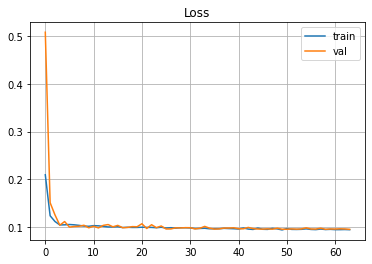

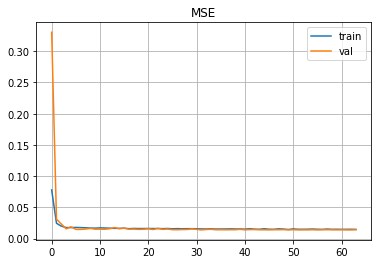

In [ ]:
# plot loss
plt.plot( history.history['loss'],'',  history.history['val_loss'],'-')
plt.title('Loss')
plt.legend(['train','val'])
plt.grid()
plt.savefig('/content/drive/MyDrive/wsp/imgs/loss10.jpg')
plt.show()
# plot mse
plt.plot(history.history['mse'],'', history.history['val_mse'],'-')
plt.title('MSE')
plt.legend(['train','val'])
plt.grid()
plt.savefig('/content/drive/MyDrive/wsp/imgs/mse10.jpg')
plt.show()


In [ ]:
def predict_one_fold(model, ds_test):
  mse = tf.keras.metrics.MeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()
  msle = tf.keras.metrics.MeanSquaredLogarithmicError()
  predictions = np.array([], dtype=np.float32).reshape(0,1)
  target = np.array([], dtype=np.float32).reshape(0,1)
  #signals = np.array([], dtype=np.float32).reshape(0,6)
  for batch in ds_test:
    data, label = batch
    preds = model(data, training=False)
    preds = preds.numpy()
    #signals = np.concatenate((signals, data), axis=0)
    mse.update_state(label, preds)
    mae.update_state(label, preds)
    msle.update_state(label, preds)
    label = label.numpy()
    target = np.vstack([target, label.reshape(-1, 1)])
    predictions = np.vstack([predictions, preds.reshape(-1, 1)])
  print('MSE:', mse.result().numpy())
  print('MAE:', mae.result().numpy())
  print('MSLE:', msle.result().numpy())
  print('---------------------------------------')
  return predictions, target


In [ ]:
def get_test_dataset(sample_name):
  ds_test= tf.data.TFRecordDataset([sample_name])
  ds_test = ds_test.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test  =  ds_test.map(preprocess)
  ds_test  = ds_test.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True)
  return ds_test

In [ ]:
test_tfrecs

'/content/drive/MyDrive/wsp/data/Binalood.tfrec'

In [ ]:
min_data, max_data, min_label, max_label = find_stats(train_tfrecs)
max_data = max_data.tolist()
min_data = min_data.tolist()

min data
[  0.           0.           0.         -18.60000038   0.        ]
max data
[  30.29999924  360.          360.           40.         1200.        ]
std data
[ 0.71320939  6.71210985 18.94165501  1.11519899 33.02555599]
mean data
[  5.52331553  48.54242493 163.28330907  15.77729289 222.05220147]
std label
[7.169572]
mean label
[332.72876]
min label
210.31071
max label
594.70905


In [ ]:
data1, label = next(iter(a))
data1.shape

TensorShape([8, 256, 5])

In [ ]:
preds = model(data1, training=False)
preds.shape

TensorShape([8, 256, 1])

**model02 : 9**

**model03 : 5**

**model04 : 5**

**model05 : 5**

**model05 : 50**

In [ ]:
BATCH_SIZE = 8
model = eUNet1D_2(kernel_size = 5)
model.load_weights('/content/drive/MyDrive/wsp/saved_model10/saved_model').expect_partial()
a = get_test_dataset(test_tfrecs)
preds, target = predict_one_fold(model, a)

MSE: 0.010506325
MAE: 0.08166102
MSLE: 0.006078821
---------------------------------------


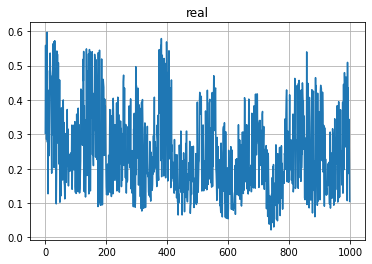

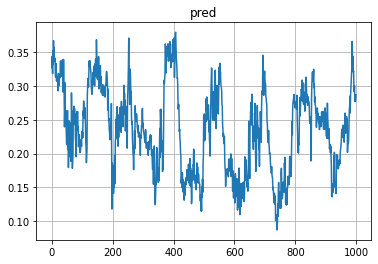

In [ ]:
# plot loss
plt.plot( target[0:1000],'')
plt.title('real')
plt.grid()
plt.savefig('/content/drive/MyDrive/wsp/real.png')
plt.show()

plt.plot(preds[0:1000],'-')
plt.title('pred')
plt.grid()
plt.savefig('/content/drive/MyDrive/wsp/pred_09.png')
plt.show()


# six fold

In [ ]:
subjects= [ 'tr03-0333',
            'tr03-0373',
            'tr03-0532',
            'tr03-1183',
            'tr04-0332',
            'tr05-0827',
            'tr05-1042',
            'tr06-0447',
            'tr03-1129',
            'tr06-1010',
            'tr03-0100',
            'tr07-0605']

In [ ]:
outlier_subjects = ['tr06-0447', 'tr06-1010', 'tr07-0605', 'tr03-0373', ]

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold1

In [ ]:
#!rm -r /content/drive/MyDrive/filtered

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(data, target):
  feature = {
      'data': _float_feature(data),
      'target': _float_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()


In [ ]:
def create_tfrecs(subjects_lists, save_path = '/content/data'):
  i = 0
  num_all = []
  with progressbar.ProgressBar(max_value=len(subjects_lists)) as bar:
    for rec in subjects_lists:
      labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + rec + '/' + rec+ '.mat?download'
      urllib.request.urlretrieve(labelURL, '/content/data.mat')

      data = io.loadmat('/content/data.mat')
      data = data['val']
      data = data.astype(np.float32)

      path_to_filtred = '/content/drive/MyDrive/eunet1d/filtered/subjects'
      af = io.loadmat(os.path.join(path_to_filtred, rec+'.mat'))
      af = af['airflow_final']
      af = af.astype(np.float32)
      data[10,:] = af
      number_of_arrays = data.shape[1]//256
      num_all.append(number_of_arrays)
      with tf.io.TFRecordWriter(os.path.join(save_path, rec + '.tfrec')) as writer:
        for j in range(number_of_arrays):
          sub_data = data[0:6,j*256:(j+1)*256]
          sub_data = sub_data.astype(np.float32)
          sub_data = sub_data.reshape(256,6)
          target = data[10,j*256:(j+1)*256]
          target = target.astype(np.float32)
          target = target.reshape(256,1)

          example = serialize_example(sub_data.reshape(-1,1), target.reshape(-1,1))
          writer.write(example)
      i +=1
      bar.update(i)
  return num_all

In [ ]:
save_path = '/content/data/'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_samples = create_tfrecs(subjects, save_path = save_path)
num_samples

In [ ]:
# Create a dictionary describing the features.
feature_description = {
    'data': tf.io.FixedLenFeature([1536], tf.float32, default_value=[0.0]*1536),
    'target': tf.io.FixedLenFeature([256], tf.float32, default_value=[0.0]*256),
  }

def _parse_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def preprocess(features,effesionet=True):
  data = features['data']
  #data = tf.io.decode_raw(data, tf.int16)
  label = features['target']
  #label = tf.io.decode_raw(label, tf.int16)
  return data, label


def normalize(data ,label):
  #standard
  data = tf.cast(data, tf.float32)
  scale = tf.constant(max_data) - tf.constant(min_data)
  offset = tf.constant(min_data)

  data -= offset
  data /= scale
  label = tf.cast(label, tf.float32)
  scale =  tf.constant([max_label]) - tf.constant([min_label])
  offset = tf.constant([min_label])
  label -= offset
  label /= scale
  return data , label

@tf.function
def augment(data,label):

  return data , label

def Resize(data,label):
  data = tf.reshape(data, [256,6])
  label = tf.reshape(label, [256,1])
  return data , label


In [ ]:
BATCH_SIZE = 64
ds_test= tf.data.TFRecordDataset(['/content/data/tr03-0100.tfrec'])
ds_test = ds_test.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test  =  ds_test.map(preprocess)
ds_test  = ds_test.map(Resize).batch(BATCH_SIZE,drop_remainder=True)

In [ ]:
data1, label = next(iter(ds_test))
data1.shape

In [ ]:
label.shape

TensorShape([64, 256, 1])

In [ ]:
def find_stats(all_tfrecs):
  ds_stat= tf.data.TFRecordDataset(all_tfrecs)
  ds_stat = ds_stat.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(100)
  ds_stat  =  ds_stat.map(preprocess)
  ds_stat  = ds_stat.map(Resize).batch(1024,drop_remainder=True)

  mean_data = np.zeros((6,))
  std_data = np.zeros((6,))
  max_data = np.ones((6,))*-100000 # -inf
  min_data = np.ones((6,))*(100000) #+inf

  mean_label = 0
  std_label = 0
  max_label = -100000000000
  min_label = 10000000000
  k = 0
  for i in ds_stat:
    data1, label = i
    mean_data = mean_data + np.mean(np.mean(data1.numpy(),axis=1),axis=0)
    std_data = std_data + np.std(np.std(data1.numpy(),axis=1),axis=0)
    mean_label = mean_label + np.mean(np.mean(label.numpy(),axis=1),axis=0)
    std_label = std_label + np.std(np.std(label.numpy(),axis=1),axis=0)

    data =np.max(np.max(data1,axis=1),axis=0)
    max_data[np.where(max_data< data)] = data[np.where(max_data< data)]
    data =np.min(np.min(data1,axis=1),axis=0)
    min_data[np.where(min_data> data)] = data[np.where(min_data> data)]

    if np.max(np.max(label.numpy(),axis=1))>max_label:
      max_label = np.max(np.max(label.numpy(),axis=1))
    if np.min(np.min(label.numpy()))<min_label:
      min_label = np.min(np.min(label.numpy()))

    k = k+1
  std_data = std_data/k
  mean_data = mean_data/k
  mean_label = mean_label/k
  std_label = std_label/k
  print('min data')
  print(min_data)
  print('max data')
  print(max_data)
  print('std data')
  print(std_data)
  print('mean data')
  print(mean_data)

  print('std label')
  print(std_label)
  print('mean label')
  print(mean_label)
  print('min label')
  print(min_label)
  print('max label')
  print(max_label)
  del ds_stat
  return min_data, max_data, min_label, max_label

In [ ]:
np.random.seed(55)
indices = np.arange(len(subjects))
np.random.shuffle(indices)
indices.tolist()

[6, 4, 0, 2, 1, 3, 9, 11, 5, 8, 7, 10]

In [ ]:
subjects_without_outliers = [subject for subject in subjects if subject not in outlier_subjects]
subjects_without_outliers

['tr03-0333',
 'tr03-0532',
 'tr03-1183',
 'tr04-0332',
 'tr05-0827',
 'tr05-1042',
 'tr03-1129',
 'tr03-0100']

In [ ]:
subjects = [subjects[i] for i in indices.tolist()]
subjects

['tr05-1042',
 'tr04-0332',
 'tr03-0333',
 'tr03-0532',
 'tr03-0373',
 'tr03-1183',
 'tr06-1010',
 'tr07-0605',
 'tr05-0827',
 'tr03-1129',
 'tr06-0447',
 'tr03-0100']

In [ ]:
all_tfrecs_witout_outliers = [ '/content/data/'+ subjects_without_outliers[i] + '.tfrec' for i in range(len(subjects_without_outliers))]
all_tfrecs_witout_outliers

['/content/data/tr03-0333.tfrec',
 '/content/data/tr03-0532.tfrec',
 '/content/data/tr03-1183.tfrec',
 '/content/data/tr04-0332.tfrec',
 '/content/data/tr05-0827.tfrec',
 '/content/data/tr05-1042.tfrec',
 '/content/data/tr03-1129.tfrec',
 '/content/data/tr03-0100.tfrec']

In [ ]:
find_stats(all_tfrecs_witout_outliers)

**so based on our observations, we choose the max = 100 and min = -100 as threshold**

let's create the new tfrecs without the noisy samples

In [ ]:
threshold_max = 41
threshold_min = -34

In [ ]:
rec = outlier_subjects[0]
labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + rec + '/' + rec+ '.mat?download'
urllib.request.urlretrieve(labelURL, '/content/data.mat')

data = io.loadmat('/content/data.mat')
data = data['val']
data = data.astype(np.float32)

path_to_filtred = '/content/drive/MyDrive/eunet1d/filtered/subjects'
af = io.loadmat(os.path.join(path_to_filtred, rec+'.mat'))
af = af['airflow_final']
af = af.astype(np.float32)

In [ ]:
af.shape

(1, 5162400)

In [ ]:
data.shape

(13, 5162400)

In [ ]:

clean_af = np.delete(af, np.where(af >= threshold_max), 1)
clean_af.shape

(1, 3176815)

In [ ]:
clean_data= np.delete(data, np.where(af >= threshold_max), 1)
clean_data.shape

(13, 3176815)

In [ ]:

clean_af2 = np.delete(clean_af, np.where(clean_af <= threshold_min), 1)
clean_af2.shape

(1, 1193682)

In [ ]:
clean_data2 = np.delete(clean_data, np.where(clean_af <= threshold_min), 1)
clean_data2.shape

(13, 1193682)

In [ ]:
!rm -r /content/data

In [ ]:
def create_tfrecs2(subjects_lists, save_path = '/content/data'):
  i = 0
  num_all = []
  with progressbar.ProgressBar(max_value=len(subjects_lists)) as bar:
    for rec in subjects_lists:
      labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + rec + '/' + rec+ '.mat?download'
      urllib.request.urlretrieve(labelURL, '/content/data.mat')

      data = io.loadmat('/content/data.mat')
      data = data['val']
      data = data.astype(np.float32)

      path_to_filtred = '/content/drive/MyDrive/eunet1d/filtered/subjects'
      af = io.loadmat(os.path.join(path_to_filtred, rec+'.mat'))
      af = af['airflow_final']
      af = af.astype(np.float32)

      clean_af = np.delete(af, np.where(af >= threshold_max), 1)
      clean_data= np.delete(data, np.where(af >= threshold_max), 1)

      af = np.delete(clean_af, np.where(clean_af <= threshold_min), 1)
      data = np.delete(clean_data, np.where(clean_af <= threshold_min), 1)

      data[10,:] = af
      number_of_arrays = data.shape[1]//256
      num_all.append(number_of_arrays)
      with tf.io.TFRecordWriter(os.path.join(save_path, rec + '.tfrec')) as writer:
        for j in range(number_of_arrays):
          sub_data = data[0:6,j*256:(j+1)*256]
          sub_data = sub_data.astype(np.float32)
          sub_data = sub_data.reshape(256,6)
          target = data[10,j*256:(j+1)*256]
          target = target.astype(np.float32)
          target = target.reshape(256,1)

          example = serialize_example(sub_data.reshape(-1,1), target.reshape(-1,1))
          writer.write(example)
      i +=1
      bar.update(i)
  return num_all

In [ ]:
save_path = '/content/data/'
if not os.path.isdir(save_path):
  os.mkdir(save_path)
num_samples = create_tfrecs2(subjects, save_path = save_path)
num_samples

100% (12 of 12) |########################| Elapsed Time: 0:04:40 Time:  0:04:40


[21144,
 21738,
 20250,
 21113,
 20256,
 21117,
 1610,
 2227,
 19589,
 25160,
 2138,
 19417]

In [ ]:
all_tfrecs_fold0 = [ '/content/data/'+ subjects[i] + '.tfrec' for i in range(12) if i>=2]
all_tfrecs_fold0

In [ ]:
min_data, max_data, min_label, max_label = find_stats(all_tfrecs_fold0 )
max_data = max_data.tolist()
min_data = min_data.tolist()

min data
[-4275. -4252. -4251. -4234. -4252. -4202.]
max data
[4417. 4410. 4427. 4419. 4431. 4419.]
std data
[25.44579222 25.44752649 25.46093955 25.4553366  25.46962522 25.47624383]
mean data
[7.88879395e-05 2.57288615e-04 2.85212199e-04 9.93525187e-04
 4.82228597e-04 5.84640503e-04]
std label
[1.6994076]
mean label
[-0.00667412]
min label
-49.99991
max label
49.99994


In [ ]:
subjects

['tr05-1042',
 'tr04-0332',
 'tr03-0333',
 'tr03-0532',
 'tr03-0373',
 'tr03-1183',
 'tr06-1010',
 'tr07-0605',
 'tr05-0827',
 'tr03-1129',
 'tr06-0447',
 'tr03-0100']

In [ ]:
#def create_tfrecs(subjects_lists, save_path = '/content/data'):
  # i = 0
  # num_all = []
  # with progressbar.ProgressBar(max_value=len(subjects_lists)) as bar:
    # for rec in subjects_lists:
      # labelURL = 'https://physionet.org/files/challenge-2018/1.0.0/training/' + rec + '/' + rec+ '.mat?download'
      # urllib.request.urlretrieve(labelURL, '/content/data.mat')

      # data = io.loadmat('/content/data.mat')
      # data = data['val']
      # data = data.astype(np.int16)
      # number_of_arrays = data.shape[1]//256
      # num_all.append(number_of_arrays)
      # with tf.io.TFRecordWriter(os.path.join(save_path, rec + '.tfrec')) as writer:
        # for j in range(number_of_arrays):
          # sub_data = data[0:6,j*256:(j+1)*256]
          # sub_data = sub_data.astype(np.int16)
          # sub_data = sub_data.reshape(256,6)
          # target = data[10,j*256:(j+1)*256]
          # target = target.astype(np.int16)
          # target = target.reshape(256,1)

          # example = serialize_example(sub_data.tostring(), target.tostring())
          # writer.write(example)
      # i +=1
      # bar.update(i)
  # return num_all

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold0

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold1

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold2

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold3

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold4

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold5

In [ ]:
def get_datasets(subjects, num_samples,
                 min_data, max_data, min_label, max_label,
                 path = '/content/data/', fold_number = 0, BATCH_SIZE = 64):
  train_tfrecs = [os.path.join(path, subjects[i]+'.tfrec') for i in range(len(subjects)) if i!=2*fold_number and i!=(2*fold_number+1)]
  indices = np.arange(len(train_tfrecs))
  np.random.shuffle(indices)
  indices = indices.tolist()
  num_samples_val = num_samples[indices[0]] + num_samples[indices[1]]
  val_tfrecs = [train_tfrecs[indices[0]],
                train_tfrecs[indices[1]]]
  train_tfrecs = [recs for recs in train_tfrecs if recs not in val_tfrecs]
  num_samples_train = 0
  for k in range(2, len(train_tfrecs)):
    num_samples_train = num_samples_train + num_samples[k]

  ds_train = tf.data.TFRecordDataset(train_tfrecs)
  ds_train = ds_train.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).prefetch(100)
  ds_train  =  ds_train.map(preprocess)#.map(agment)
  ds_train  = ds_train.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()


  ds_val= tf.data.TFRecordDataset(val_tfrecs)
  ds_val = ds_val.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_val  =  ds_val.map(preprocess)
  ds_val  = ds_val.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

  num_samples_test = num_samples[2*fold_number] + num_samples[2*fold_number+1]
  ds_test= tf.data.TFRecordDataset([os.path.join(path, subjects[fold_number*2]+'.tfrec'),
                                   os.path.join(path, subjects[fold_number*2+1]+'.tfrec')])

  ds_test = ds_test.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test  =  ds_test.map(preprocess)
  ds_test  = ds_test.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True).repeat()

  return ds_train, ds_val, ds_test, num_samples_train, num_samples_test, num_samples_val

In [ ]:
BATCH_SIZE = 64

In [ ]:
fold_number = 0
path= '/content/data'
train_tfrecs = [os.path.join(path, subjects[i]+'.tfrec') for i in range(len(subjects)) if i!=2*fold_number and i!=(2*fold_number+1)]
min_data, max_data, min_label, max_label = find_stats(train_tfrecs)
max_data = max_data.tolist()
min_data = min_data.tolist()

a,b,c, d,e,f = get_datasets(subjects, num_samples,
                            min_data, max_data, min_label, max_label,
                            path = '/content/data/', fold_number = 0, BATCH_SIZE = BATCH_SIZE)

min data
[-4275. -4252. -4251. -4234. -4252. -4202.]
max data
[4417. 4410. 4427. 4419. 4431. 4419.]
std data
[26.44840025 26.45628394 26.46351025 26.45626756 26.50211073 26.50308111]
mean data
[0.00017578 0.00061197 0.00122442 0.00191732 0.00051162 0.00028695]
std label
[1.5336614]
mean label
[-0.00354299]
min label
-49.999886
max label
49.99994


In [ ]:
data1, label = next(iter(a))
data1.shape

TensorShape([64, 256, 6])

In [ ]:
a = label.numpy()
np.max(np.max(a, axis=1), axis=0)

array([0.56647784], dtype=float32)

In [ ]:
c

<RepeatDataset shapes: ((64, 256, 6), (64, 256, 1)), types: (tf.float32, tf.float32)>

In [ ]:
np.sum(num_samples)

204007

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def train_one_fold(model, subjects, num_samples,
                   min_data, max_data, min_label, max_label,
                   path = '/content/data/', fold_number = 0, EPOCHS = 50):
  ds_train, ds_val, ds_test, num_samples_train, num_samples_test, num_samples_val = get_datasets(subjects = subjects,
                                                                                                 num_samples =num_samples,
                                                                                                 min_data = min_data,
                                                                                                 max_data = max_data,
                                                                                                 min_label = min_label,
                                                                                                 max_label = max_label,
                                                                                                 path = path,
                                                                                                 fold_number = fold_number,
                                                                                                 BATCH_SIZE = BATCH_SIZE)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
  #lr_sc = tf.keras.optimizers.schedules.ExponentialDecay(1e-4, TRAIN_STEPS ,decay_rate=0.96)
  #optimizer = tf.keras.optimizers.Adam(lr_sc,beta_1=0.9,beta_2=0.999)
  model.compile(loss= 'mae',
                optimizer = optimizer,
                metrics=['mse', 'mean_squared_logarithmic_error'])

  # checkpoint
  if not os.path.isdir('/content/drive/MyDrive/eunet1d'):
    os.mkdir('/content/drive/MyDrive/eunet1d')
  if not os.path.isdir('/content/drive/MyDrive/eunet1d/fold_33' + str(fold_number)):
    os.mkdir('/content/drive/MyDrive/eunet1d/fold_33'+str(fold_number))

  filepath='/content/drive/MyDrive/eunet1d/fold_33' + str(fold_number)+ "/saved_model"
  checkpoint = ModelCheckpoint(filepath, monitor='val_mse',
                               save_weights_only=True,
                               verbose=1, save_best_only=True,
                               mode='min')
  #callbacks_list = [ checkpoint,tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,) ]
  callbacks_list = [ checkpoint]
  TRAIN_STEPS = num_samples_train//BATCH_SIZE + 1
  VAL_STEPS = num_samples_val//BATCH_SIZE
  history = model.fit(ds_train,
                      epochs= EPOCHS,
                      validation_data = ds_val,
                      steps_per_epoch= TRAIN_STEPS,
                      validation_steps = VAL_STEPS,
                      callbacks = callbacks_list)

  return history, ds_test, num_samples_test

In [ ]:
del max_data
del min_data
del max_label
del min_label
del model

In [ ]:
#!rm -r /content/drive/MyDrive/eunet1d/fold_0

In [ ]:
EPOCHS = 50
load = True
BATCH_SIZE = 128
for f in range(3,6):
  if not load:
    model = eUNet1D(kernel_size = 50)
  else:
    model = eUNet1D(kernel_size = 50)
    model.load_weights('/content/drive/MyDrive/eunet1d/fold_33/saved_model')
    load = False
  if f == 3 and True:
    EPOCHS = 33
  else:
    EPOCHS = 50
  path = '/content/data'
  train_tfrecs = [os.path.join(path, subjects[i]+'.tfrec') for i in range(len(subjects)) if i!=2*f and i!=(2*f+1)]
  min_data, max_data, min_label, max_label = find_stats(train_tfrecs)
  max_data = max_data.tolist()
  min_data = min_data.tolist()

  history, ds_test, num_samples_test = train_one_fold(model,
                                                      subjects,
                                                      num_samples,
                                                      min_data,
                                                      max_data,
                                                      min_label,
                                                      max_label,
                                                      path = '/content/data/',
                                                      fold_number =f,
                                                      EPOCHS = EPOCHS)

min data
[-4252. -4258. -4209. -4251. -4200. -4252.]
max data
[4387. 4380. 4389. 4385. 4393. 4388.]
std data
[25.39431661 25.39165189 25.39412934 25.40022884 25.4458338  25.44797304]
mean data
[0.00359504 0.00346752 0.00351701 0.0040886  0.00400072 0.00382402]
std label
[1.2886109]
mean label
[0.03133305]
min label
-33.999912
max label
40.99993
Epoch 1/50
677/677 [==============================] - 1290s 2s/step - loss: 0.0524 - mse: 0.0064 - mean_squared_logarithmic_error: 0.0029 - val_loss: 0.1146 - val_mse: 0.0221 - val_mean_squared_logarithmic_error: 0.0106

Epoch 00001: val_mse improved from inf to 0.02211, saving model to /content/drive/MyDrive/eunet1d/fold_3/saved_model
Epoch 2/50
677/677 [==============================] - 1251s 2s/step - loss: 0.0368 - mse: 0.0027 - mean_squared_logarithmic_error: 0.0013 - val_loss: 0.1099 - val_mse: 0.0206 - val_mean_squared_logarithmic_error: 0.0099

Epoch 00002: val_mse improved from 0.02211 to 0.02058, saving model to /content/drive/MyDrive/

KeyboardInterrupt: ignored

# prediction

In [ ]:
def predict_one_fold(model, ds_test):
  mse = tf.keras.metrics.MeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()
  msle = tf.keras.metrics.MeanSquaredLogarithmicError()
  predictions = np.array([], dtype=np.float32).reshape(0,1)
  target = np.array([], dtype=np.float32).reshape(0,1)
  signals = np.array([], dtype=np.float32).reshape(0,6)
  for batch in ds_test:
    data, label = batch
    preds = model.predict(data)
    data = data.numpy()
    data = data.reshape(BATCH_SIZE*256, 6)
    signals = np.concatenate((signals, data), axis=0)
    mse.update_state(label, preds)
    mae.update_state(label, preds)
    msle.update_state(label, preds)
    label = label.numpy()
    target = np.vstack([target, label.reshape(-1, 1)])
    predictions = np.vstack([predictions, preds.reshape(-1, 1)])
  print('MSE:', mse.result().numpy())
  print('MAE:', mae.result().numpy())
  print('MSLE:', msle.result().numpy())
  print('---------------------------------------')
  return predictions, signals, target


In [ ]:
def get_test_dataset(sample_name, path = '/content/data'):
  ds_test= tf.data.TFRecordDataset([os.path.join(path, sample_name+'.tfrec')])

  ds_test = ds_test.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test  =  ds_test.map(preprocess)
  ds_test  = ds_test.map(Resize).map(normalize).batch(BATCH_SIZE,drop_remainder=True)
  return ds_test

In [ ]:
path= '/content/data'
f=4
train_tfrecs = [os.path.join(path, subjects[i]+'.tfrec') for i in range(len(subjects)) if i!=2*f or i!=(2*f+1)]
min_data, max_data, min_label, max_label = find_stats(train_tfrecs)
max_data = max_data.tolist()
min_data = min_data.tolist()

min data
[-4252. -4258. -4209. -4251. -4200. -4252.]
max data
[4387. 4380. 4389. 4385. 4393. 4388.]
std data
[25.50174839 25.49655818 25.48721858 25.49365985 25.53923994 25.5465007 ]
mean data
[0.00151198 0.00130537 0.00142522 0.00196848 0.00201236 0.00169828]
std label
[1.409408]
mean label
[0.09419065]
min label
-33.999958
max label
40.99993


In [ ]:
BATCH_SIZE = 128
for f in range(1):
  model = eUNet1D(kernel_size = 50)
  model.load_weights('/content/drive/MyDrive/eunet1d/fold_00/saved_model')
  ds_test = get_test_dataset(subjects[2*f], path = '/content/data')
  preds, signals = predict_one_fold(model, ds_test)
  io.savemat(subjects[2*f]+'.mat', {'predictions': preds})
  io.savemat(subjects[2*f]+'_eeg.mat', {'eegs': signals})

  ds_test = get_test_dataset(subjects[2*f+1], path = '/content/data')
  preds, signals= predict_one_fold(model, ds_test)
  io.savemat(subjects[2*f+1]+'.mat', {'predictions': preds})
  io.savemat(subjects[2*f+1]+'_eeg.mat', {'eegs': signals})


MSE: 0.0010678495
MAE: 0.02558168
MSLE: 0.0005083696
---------------------------------------
MSE: 0.0027442758
MAE: 0.041652754
MSLE: 0.0012997959
---------------------------------------


In [ ]:
scale = max_label - min_label
offset = min_label

In [ ]:
f = 4
BATCH_SIZE = 128
model = eUNet1D(kernel_size = 50)
model.load_weights('/content/drive/MyDrive/eunet1d/fold_4/saved_model').expect_partial()
a = get_test_dataset(subjects[0], path = '/content/data')
preds, signals, target = predict_one_fold(model, a)

MSE: 0.001049589
MAE: 0.02537443
MSLE: 0.00049965375
---------------------------------------


In [ ]:
a = get_test_dataset(subjects[2*f], path = '/content/data')
target = np.array([], dtype=np.float32).reshape(0,1)
for batch in a:
  data, label = batch
  label = label.numpy()
  target = np.vstack([target, label.reshape(-1, 1)])

In [ ]:
target.shape

(5406720, 1)

In [ ]:
preds.shape

(5406720, 1)

In [ ]:
np.linalg.norm(target-preds, ord=2, axis = 0)/np.linalg.norm(target, ord=2, axis = 0)

array([0.10827047], dtype=float32)

In [ ]:
np.linalg.norm(target-preds, ord=2)/np.linalg.norm(target, ord=2)

0.07190952

In [ ]:
target.shape

(5406720, 1)

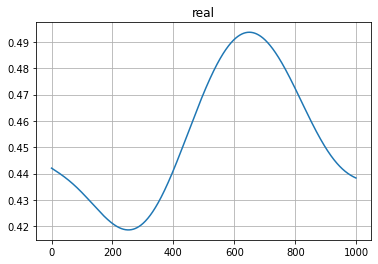

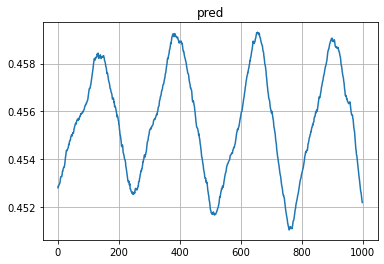

In [ ]:
# plot loss
plt.plot( target[1000000:1000000+1000,0],'')
plt.title('real')
plt.grid()
plt.show()

plt.plot(filt[1000000:1000000+1000],'-')
plt.title('pred')
plt.grid()
plt.show()


In [ ]:
from scipy.signal import savgol_filter
filt = savgol_filter(preds.reshape(-1,), 199, 2)

In [ ]:
label = label.numpy()

In [ ]:
label[:20,:]

In [ ]:
max(preds)

array([0.8613609], dtype=float32)

In [ ]:
max(label)

array([0.6442617], dtype=float32)

In [ ]:
preds[:20]

In [ ]:
b = label*scale+ offset
b[:20]

In [ ]:
label[:20]

In [ ]:
b = preds*scale+ offset
b.astype(np.int32)[:20,:]

In [ ]:
scale =  tf.constant([5983.0]) + tf.constant([5815.0])
offset = tf.constant([-5815.0])